# Getting started

In the following it is showed how to setup optimization problems in BoFire and how to use strategies to solve them.

## Setting up the optimization problem

In BoFire, an optimization problem is defined by defining a domain containing input and output features as well as constraints (optional).

### Features

Input features can be continuous, discrete, categorical, or categorical with descriptors:

In [ ]:
from bofire.data_models.features.api import (
    CategoricalDescriptorInput,
    CategoricalInput,
    ContinuousInput,
    DiscreteInput,
)


x1 = ContinuousInput(key="x1", bounds=(0, 1))
x2 = ContinuousInput(key="x2", bounds=(0, 1))
x3 = ContinuousInput(key="x3", bounds=(0, 1))
x4 = DiscreteInput(key="x4", values=[1, 2, 5, 7.5])
x5 = CategoricalInput(key="x5", categories=["A", "B", "C"], allowed=[True, True, False])
x6 = CategoricalDescriptorInput(
    key="x6",
    categories=["c1", "c2", "c3"],
    descriptors=["d1", "d2"],
    values=[[1, 2], [2, 5], [1, 7]],
)

As output features, currently only continuous output features are supported. Each output feature should have an objective, which can be a minimize or maximize objective. Furthermore, we can define weights between 0 and 1 in case the objectives should not be weighted equally.

In [ ]:
from bofire.data_models.features.api import ContinuousOutput
from bofire.data_models.objectives.api import MaximizeObjective, MinimizeObjective


objective1 = MaximizeObjective(
    w=1.0,
    bounds=[0.0, 1.0],
)
y1 = ContinuousOutput(key="y1", objective=objective1)

objective2 = MinimizeObjective(w=1.0)
y2 = ContinuousOutput(key="y2", objective=objective2)

In- and output features are collected in respective feature lists.

In [ ]:
from bofire.data_models.domain.api import Inputs, Outputs


input_features = Inputs(features=[x1, x2, x3, x4, x5, x6])
output_features = Outputs(features=[y1, y2])

A summary of the constraints can be obtained by the method `get_reps_df`:

In [ ]:
input_features.get_reps_df()

In [ ]:
output_features.get_reps_df()

Individual features can be retrieved by name.


In [ ]:
x5 = input_features.get_by_key("x5")
x5

This is also possible with list of feature names.

In [ ]:
input_features.get_by_keys(["x5", "x2"])

Features of a specific type can be returned by the `get` method, by default it returns all features that are an instance of the provided class.

In [ ]:
input_features.get(CategoricalInput)

By using the `exact` argument one can force it to only return feature of the exact same class.

In [ ]:
input_features.get(CategoricalInput, exact=True)

The `get_keys` method follows the same logic as the `get` method but returns just the keys of the features instead of the features itself.

In [ ]:
input_features.get_keys(CategoricalInput)

The input feature container further provides methods to return a feature container with only all fixed or all free features.

In [ ]:
free_inputs = input_features.get_free()
fixed_inputs = input_features.get_fixed()

One can uniformly sample from individual input features.

In [ ]:
x5.sample(2)

Or directly from input feature containers, uniform, sobol and LHS sampling is possible. A default, uniform sampling is used.

In [ ]:
from bofire.data_models.enum import SamplingMethodEnum


X = input_features.sample(n=10, method=SamplingMethodEnum.LHS)

X

### Constraints

The search space can be further defined by constraints on the input features. BoFire supports linear equality and inequality constraints, as well as non-linear equality and inequality constraints.

#### Linear constraints

`LinearEqualityConstraint` and `LinearInequalityConstraint` are expressions of the form $\sum_i a_i x_i = b$ or $\leq b$ for equality and inequality constraints respectively.
They take a list of names of the input features they are operating on, a list of left-hand-side coefficients $a_i$ and a right-hand-side constant $b$.

In [ ]:
from bofire.data_models.constraints.api import (
    LinearEqualityConstraint,
    LinearInequalityConstraint,
)


# A mixture: x1 + x2 + x3 = 1
constr1 = LinearEqualityConstraint(
    features=["x1", "x2", "x3"],
    coefficients=[1, 1, 1],
    rhs=1,
)

# x1 + 2 * x3 < 0.8
constr2 = LinearInequalityConstraint(
    features=["x1", "x3"],
    coefficients=[1, 2],
    rhs=0.8,
)

Linear constraints can only operate on `ContinuousInput` features.

#### Nonlinear constraints 

`NonlinearEqualityConstraint` and `NonlinearInequalityConstraint` take any expression that can be evaluated by [pandas.eval](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.eval.html), including mathematical operators such as `sin`, `exp`, `log10` or exponentiation. So far, they cannot be used in any optimizations.

In [ ]:
from bofire.data_models.constraints.api import NonlinearEqualityConstraint


# The unit circle: x1**2 + x2**2 = 1
const3 = NonlinearEqualityConstraint(expression="x1**2 + x2**2 - 1")
const3

NonlinearEqualityConstraint(type='NonlinearEqualityConstraint', expression='x1**2 + x2**2 - 1', features=None, jacobian_expression=None)

#### Combinatorial constraint

Use `NChooseKConstraint` to express that we only want to have $k$ out of the $n$ parameters to take positive values.
Think of a mixture, where we have long list of possible ingredients, but want to limit number of ingredients in any given recipe.

In [ ]:
from bofire.data_models.constraints.api import NChooseKConstraint


# Only 2 or 3 out of 3 parameters can be greater than zero
constr5 = NChooseKConstraint(
    features=["x1", "x2", "x3"],
    min_count=2,
    max_count=3,
    none_also_valid=True,
)
constr5

Note that we have to set a boolean, if None is also a valid selection, e.g. if we want to have 2 or 3 or none of the ingredients in our recipe.

Similar to the features, constraints can be grouped in a container which acts as the union constraints.

In [ ]:
from bofire.data_models.domain.api import Constraints


constraints = Constraints(constraints=[constr1, constr2])

A summary of the constraints can be obtained by the method `get_reps_df`:

In [ ]:
constraints.get_reps_df()

We can check whether a point satisfies individual constraints or the list of constraints.

In [ ]:
constr2.is_fulfilled(X).values

Output constraints can be setup via sigmoid-shaped objectives passed as argument to the respective feature, which can then also be plotted.


In [ ]:
from bofire.data_models.objectives.api import MinimizeSigmoidObjective
from bofire.plot.api import plot_objective_plotly


output_constraint = MinimizeSigmoidObjective(w=1.0, steepness=10, tp=0.5)
y3 = ContinuousOutput(key="y3", objective=output_constraint)

output_features = Outputs(features=[y1, y2, y3])

fig = plot_objective_plotly(feature=y3, lower=0, upper=1)

fig.show()

### The domain

The domain holds then all information about an optimization problem and can be understood as a search space definition.

In [ ]:
from bofire.data_models.domain.api import Domain


domain = Domain(inputs=input_features, outputs=output_features, constraints=constraints)

NameError: name 'constraints' is not defined

In addition one can instantiate the domain also just from lists.

In [ ]:
domain_single_objective = Domain.from_lists(
    inputs=[x1, x2, x3, x4, x5, x6],
    outputs=[y1],
    constraints=[],
)

## Optimization

To solve the optimization problem, we further need a solving strategy. BoFire supports strategies without a prediction model such as a random strategy and predictive strategies which are based on a prediction model.

All strategies contain an `ask` method returning a defined number of candidate experiments.

### Random Strategy

In [ ]:
import bofire.strategies.api as strategies
from bofire.data_models.strategies.api import RandomStrategy


strategy_data_model = RandomStrategy(domain=domain)

random_strategy = strategies.map(strategy_data_model)
random_candidates = random_strategy.ask(2)

random_candidates

/home/linznedd/miniforge3/envs/bofire/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'domain' is not defined

### Single objective Bayesian Optimization strategy

Since a predictive strategy includes a prediction model, we need to generate some historical data, which we can afterwards pass as training data to the strategy via the tell method.

For didactic purposes we just choose here from one of our benchmark methods.

In [ ]:
from bofire.benchmarks.single import Himmelblau


benchmark = Himmelblau()

(benchmark.domain.inputs + benchmark.domain.outputs).get_reps_df()

Generating some initial data works as follows:

In [ ]:
samples = benchmark.domain.inputs.sample(10)

experiments = benchmark.f(samples, return_complete=True)

experiments

Let's setup the SOBO strategy and ask for a candidate.

In [ ]:
from bofire.data_models.acquisition_functions.api import qLogNEI
from bofire.data_models.strategies.api import SoboStrategy


sobo_strategy_data_model = SoboStrategy(
    domain=benchmark.domain,
    acquisition_function=qLogNEI(),
)

sobo_strategy = strategies.map(sobo_strategy_data_model)

sobo_strategy.tell(experiments=experiments)

sobo_strategy.ask(candidate_count=1)

### Design of Experiments

As a simple example for the DoE functionalities we consider the task of finding a D-optimal design for a fully-quadratic model with three design variables with bounds (0,1) and a mixture constraint.

We define the design space including the constraint as a domain. Then we pass it to the optimization routine and specify the model. If the user does not indicate a number of experiments it will be chosen automatically based on the number of model terms.

In [ ]:
import numpy as np

from bofire.data_models.strategies.api import DoEStrategy
from bofire.data_models.strategies.doe import DOptimalityCriterion


domain = Domain(inputs=[x1, x2, x3], outputs=[y1], constraints=[constr1])
data_model = DoEStrategy(
    domain=domain,
    criterion=DOptimalityCriterion(formula="fully-quadratic"),
)
strategy = strategies.map(data_model=data_model)
candidates = strategy.ask(candidate_count=12)
np.round(candidates, 3)

,x1,x2,x3
0,-0.0,1.0,-0.0
1,-0.0,0.5,0.5
2,-0.0,-0.0,1.0
3,0.5,0.5,-0.0
4,0.5,-0.0,0.5
5,0.5,0.5,-0.0
6,1.0,-0.0,-0.0
7,-0.0,0.5,0.5
8,-0.0,1.0,-0.0
9,-0.0,0.5,0.5


The resulting design looks like this:

NameError: name 'res' is not defined

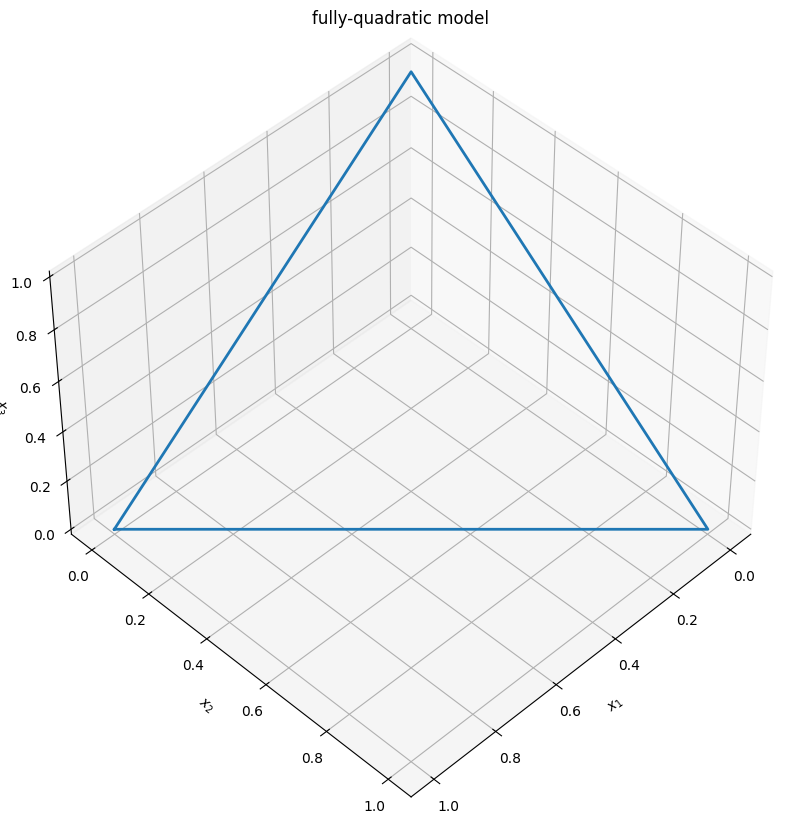

In [ ]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=((10, 10)))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(45, 45)
ax.set_title("fully-quadratic model")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.rcParams["figure.figsize"] = (10, 8)

# plot feasible polytope
ax.plot(xs=[1, 0, 0, 1], ys=[0, 1, 0, 0], zs=[0, 0, 1, 0], linewidth=2)

# plot D-optimal solutions
ax.scatter(
    xs=candidates["x1"],
    ys=candidates["x2"],
    zs=candidates["x3"],
    marker="o",
    s=40,
    color="orange",
)